In [1]:
# module import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from haversine import haversine
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [2]:
# split time info method
def month_col(raw):
    return int(raw[5:7])
def day_col(raw):
    return int(raw[8:10])
def hour_col(raw):
    return int(raw[11:13])
def year_col(raw):
    return int(raw[0:4])

# deleting data (out of city) method
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude > BB[0]) & (df.pickup_longitude < BB[1]) & \
           (df.pickup_latitude > BB[2]) & (df.pickup_latitude < BB[3]) & \
           (df.dropoff_longitude > BB[0]) & (df.dropoff_longitude < BB[1]) & \
           (df.dropoff_latitude > BB[2]) & (df.dropoff_latitude < BB[3])
# Latitude, longitude of New york city 
BB = (-74.5, -72.8, 40.5, 41.8)

# Showing map with location info method 
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    plt.show()
    
# Deleting data (in the water) method
# changing scale
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'),\
(dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')
# Removing method
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')
    
    BB = (-74.5, -72.8, 40.5, 41.8)
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    return df[idx]


# Showing boxplot method
def showing_boxplot(df, col, min_num, max_num):
    plt.boxplot(df[(df[col]<max_num)&(df[col]>min_num)][col], 0, 'gD')
    plt.show()

# Calculate absolute distance method   
def cal_ab_len(raw):
    start_point = (raw["pickup_latitude"], raw["pickup_longitude"])
    end_point = (raw["dropoff_latitude"] , raw["dropoff_longitude"])
    ab_length = haversine(start_point, end_point)
    return ab_length

# Calculate euclidean distance method  
def cal_ucl_len(raw):
    start_point = (raw.pickup_latitude, raw.pickup_longitude)
    middle_point = (raw.pickup_latitude, raw.dropoff_longitude)
    end_point = (raw.dropoff_latitude , raw.dropoff_longitude)
    len_1 = haversine(start_point, middle_point)
    len_2 = haversine(middle_point, end_point)
    return len_1+len_2


# Change bin info to noraml distribution value
def change_to_num(raw):
    if (raw<0.26)&(raw>=0):
        return 1
    elif (raw<0)&(raw>=-0.26):
        return 2
    elif (raw<0.53)&(raw>=0.26):
        return 3
    elif (raw<-0.26)&(raw>=-0.53):
        return 4
    elif (raw<0.85)&(raw>=0.53):
        return 5
    elif (raw<-0.53)&(raw>=-0.85):
        return 6
    elif (raw<1.29)&(raw>=0.85):
        return 7
    elif (raw<-0.85)&(raw>=-1.29):
        return 8
    elif (raw>1.29):
        return 9
    else :
        return 10

    
# Change to positive & negative columns method
def return_positive(raw):
    if raw>0:
        return raw
    else :
        return 0
def return_negative(raw):
    if raw<0:
        return -raw
    else :
        return 0

# Make hour data to dummy variable
def input_night(raw):
    if raw.hour<=6:
        return 1
    else:
        return 0
    
 # Show kdeplot_ for dummy variable   
def show_kdeplot_of_dummy(col):
    sns.kdeplot(data_3[data_3[col]==10].fare_amount, color="r", label=col+"=10")
    sns.kdeplot(data_3[data_3[col]==9].fare_amount, color="b", label=col+"=9")
    sns.kdeplot(data_3[data_3[col]==8].fare_amount, color="purple", label=col+"=8")
    sns.kdeplot(data_3[data_3[col]==7].fare_amount, color="teal", label=col+"=7")
    sns.kdeplot(data_3[data_3[col]==6].fare_amount, color="pink", label=col+"=6")
    sns.kdeplot(data_3[data_3[col]==5].fare_amount, color="y", label=col+"=5")
    sns.kdeplot(data_3[data_3[col]==4].fare_amount, color="orange", label=col+"=4")
    sns.kdeplot(data_3[data_3[col]==3].fare_amount, color="black", label=col+"=3")
    sns.kdeplot(data_3[data_3[col]==2].fare_amount, color="green", label=col+"=2")
    sns.kdeplot(data_3[data_3[col]==1].fare_amount, color="grey", label=col+"=1")
    plt.show()

# Regression Modeling

### 목차
    1. 데이터 설명
    2. 데이터 전처리
    3. 상관 분석
    4. 모델링
    5. 결과 분석

# 1. Data Description

데이터 출처 : 캐글 오픈 데이터\
칼럼 설명 :
    1. key : 레코드 ID
    2. fare_amount : 측정된 요금
    3. pidckup_datetime : 택시 탑승 시간 정보
    4. pickup_longitude : 탑승 위치 경도
    5. pickup_latitude : 탑승 위치 위도
    6. dropoff_longitude : 하차 위치 경도
    7. dropoff_latitude : 하차 위치 위도
    8. passenger_count : 탑승객 수

In [4]:
data = pd.read_csv("./Data/train.csv", nrows=5000000)
print(data.shape)
data.head()

(5000000, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# 2. Data preprocessing

    1. 시간 데이터 연, 월, 일, 시간 단위로 쪼개기
    2. 뉴욕 시를 벗어나거나 물 위에 있는 데이터 삭제
    3. 승객 수, 요금이 outlier로 의심 되는 데이터 삭제
    4. 출발, 도착 위도 경도로 둘 사이의 거리를 절대 거리, 유클리디안 거리로 계산하여 칼럼으로 추가
    5. 도시의 중심부 부터 외곽에 대한 정보를 더미 변수로 만들고 구간에 대한 이동 정보를 반영
    6. 이동 방향, 크기에 대한 벡터량을 나타낸 칼럼 추가

### 시간 데이터 변환

In [5]:
# drop Key columns
data.drop(columns=["key"], inplace=True)
print(data.shape)


# 시간 데이터 변환
data["year"]= data["pickup_datetime"].apply(year_col)
data["month"]= data["pickup_datetime"].apply(month_col)
data["day"]= data["pickup_datetime"].apply(day_col)
data["hour"]= data["pickup_datetime"].apply(hour_col)
# drop original date column
data.drop(columns=["pickup_datetime"], inplace=True)
print(data.shape)

(5000000, 7)
(5000000, 10)


### 이상한 위치에 있는 데이터 삭제

After size: 4893893


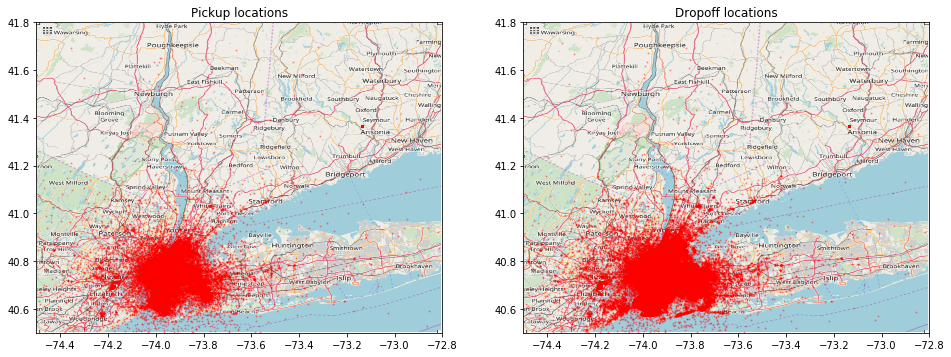

Deleting data of wrong location(in th water)


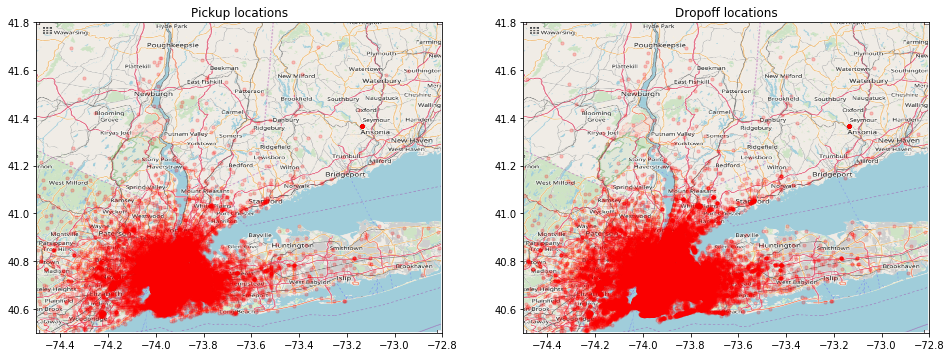

(4892924, 10)


In [6]:
# Cleansing outlier data of location info columns
df_train = data[select_within_boundingbox(data, BB)]
print('After size: %d' % len(df_train))

# Get City map & Showing
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')
plot_on_map(df_train, BB, nyc_map, s=1, alpha=0.3)

# Cleansing outlier data of wrong location
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
pickup_x, pickup_y = lonlat_to_xy(df_train.pickup_longitude, df_train.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df_train.dropoff_longitude, df_train.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
print("Deleting data of wrong location(in th water)")
df_train = remove_datapoints_from_water(df_train)
plot_on_map(df_train, BB, nyc_map)
print(df_train.shape)

In [8]:
# Loading bacjup data
data_clean1 = df_train.copy()
print(data_clean1.shape)
data_clean1.head()

(4892924, 10)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7


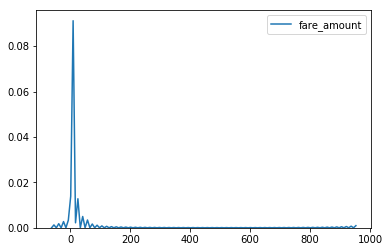

In [9]:
sns.kdeplot(data_clean1.fare_amount)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


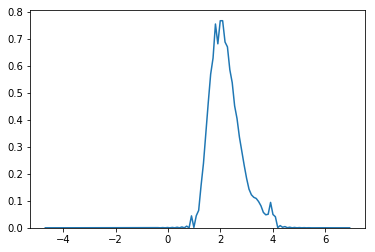

In [10]:
sns.kdeplot(np.log(data_clean1.fare_amount.values))

금액의 분포가 극단으로 대조 되어 있어 로그 스케일 조정으로 분포가 어느 정도 모아짐을 확인

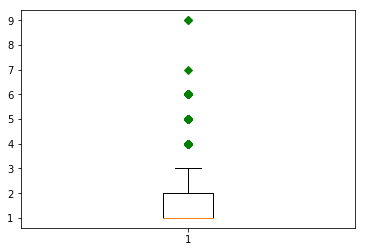

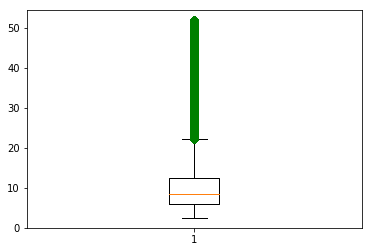

In [11]:
showing_boxplot(data_clean1,"passenger_count",0,10 )
showing_boxplot(data_clean1,"fare_amount",2.5,52 )

승객 데이터에 이상치로 의심되는 데이터 확인

In [12]:
# 요금 데이터, 승객 데이터 이상치 제거
data_2 = data_clean1[(data_clean1.fare_amount<30)&(data_clean1.passenger_count>0)&(data_clean1.passenger_count<5)]
print(data_2.shape)

(4200638, 10)


### 절대 거리 유클리디안 거리 데이터 생성 및 밀집도 정보를 담은 데이터 생성

In [13]:
# Calculate absolute distance
data_2["ab_length"] = data_2.apply(cal_ab_len, axis=1)
# Calculate euclidian distance
data_2["ucl_length"] = data_2.apply(cal_ucl_len, axis=1)

# Create bin columns
pickup_longitude_mean=data_2["pickup_longitude"].mean()
pickup_longitude_std =data_2["pickup_longitude"].std()
pickup_latitude_mean =data_2["pickup_latitude"].mean()
pickup_latitude_std  =data_2["pickup_latitude"].std()
dropoff_longitude_mean=data_2["dropoff_longitude"].mean()
dropoff_longitude_std =data_2["dropoff_longitude"].std()
dropoff_latitude_mean =data_2["dropoff_latitude"].mean()
dropoff_latitude_std  =data_2["dropoff_latitude"].std()
data_2["pickup_longitude_norm"] = \
(data_2["pickup_longitude"] - pickup_longitude_mean)/pickup_longitude_std
data_2["pickup_latitude_norm"] = \
(data_2["pickup_latitude"] - pickup_latitude_mean)/pickup_latitude_std
data_2["dropoff_longitude_norm"] = \
(data_2["dropoff_longitude"] - dropoff_longitude_mean)/dropoff_longitude_std
data_2["dropoff_latitude_norm"] = \
(data_2["dropoff_latitude"] -dropoff_latitude_mean)/dropoff_latitude_std
data_2["vector_lati"] = data_2["dropoff_latitude"] - data_2["pickup_latitude"]
data_2["vector_long"] = data_2["dropoff_longitude"] - data_2["pickup_longitude"]

# Change to dummy columns
data_2["pickup_longitude_dummy"] = data_2["pickup_longitude_norm"].apply(change_to_num)
data_2["pickup_latitude_dummy"] = data_2["pickup_latitude_norm"].apply(change_to_num)
data_2["dropoff_longitude_dummy"] = data_2["dropoff_longitude_norm"].apply(change_to_num)
data_2["dropoff_latitude_dummy"] = data_2["dropoff_latitude_norm"].apply(change_to_num)

# Create & Make dummy columns
data_2["vector_long_east"] = 0
data_2["vector_long_west"] = 0
data_2["vector_lati_north"] = 0
data_2["vector_lati_south"] = 0
data_2["vector_long_east"]=data_2["vector_long"].apply(return_positive)
data_2["vector_long_west"]=data_2["vector_long"].apply(return_negative)
data_2["vector_lati_north"]=data_2["vector_long"].apply(return_positive)
data_2["vector_lati_south"]=data_2["vector_long"].apply(return_negative)


# Create boarding_landing_info & sector_moving_info
data_2["boarding_landing_info"] = np.sqrt(
    data_2["dropoff_longitude_dummy"]*data_2["dropoff_longitude_dummy"]
    +data_2["dropoff_latitude_dummy"]*data_2["dropoff_latitude_dummy"]
    +data_2["pickup_longitude_dummy"]*data_2["pickup_longitude_dummy"]
    +data_2["pickup_latitude_dummy"]*data_2["pickup_latitude_dummy"]
)
data_2["sector_moving_info"] = np.sqrt(
    (data_2["dropoff_longitude_dummy"]-data_2["pickup_longitude_dummy"])*\
    (data_2["dropoff_longitude_dummy"]-data_2["pickup_longitude_dummy"])
    + (data_2["dropoff_latitude_dummy"]-data_2["pickup_latitude_dummy"])*\
    (data_2["dropoff_latitude_dummy"]-data_2["pickup_latitude_dummy"])
)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

In [14]:
# Loading Data
data_3 = data_2.copy()
print(data_3.shape)
data_3.head()

(4200638, 28)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,...,pickup_longitude_dummy,pickup_latitude_dummy,dropoff_longitude_dummy,dropoff_latitude_dummy,vector_long_east,vector_long_west,vector_lati_north,vector_lati_south,boarding_landing_info,sector_moving_info
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,...,9,8,9,10,0.002701,0.000000,0.002701,0.000000,18.055470,2.000000
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,...,8,10,2,7,0.036780,0.000000,0.036780,0.000000,14.730920,6.708204
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,...,2,3,4,2,0.000000,0.008504,0.000000,0.008504,5.744563,2.236068
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,...,4,6,4,1,0.000000,0.004437,0.000000,0.004437,8.306624,5.000000
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,...,3,5,5,7,0.011440,0.000000,0.011440,0.000000,10.392305,2.828427


# 3. Finding Correlation

    1. 상관 분석으로 상관도가 없는 데이터 삭제 또는 수정
    2. 시간 정보를 상관도가 있는 데이터로 변환

### 상관 분석

In [15]:
data_3.corr().fare_amount

fare_amount                1.000000
pickup_longitude           0.105179
pickup_latitude           -0.064045
dropoff_longitude          0.195656
dropoff_latitude          -0.075224
passenger_count            0.018021
year                       0.118308
month                      0.026175
day                        0.001099
hour                      -0.018575
ab_length                  0.748790
ucl_length                 0.721011
pickup_longitude_norm      0.105179
pickup_latitude_norm      -0.064045
dropoff_longitude_norm     0.195656
dropoff_latitude_norm     -0.075224
vector_lati               -0.019111
vector_long                0.102977
pickup_longitude_dummy     0.148923
pickup_latitude_dummy      0.113700
dropoff_longitude_dummy    0.213541
dropoff_latitude_dummy     0.213511
vector_long_east           0.432568
vector_long_west           0.285391
vector_lati_north          0.432568
vector_lati_south          0.285391
boarding_landing_info      0.320932
sector_moving_info         0

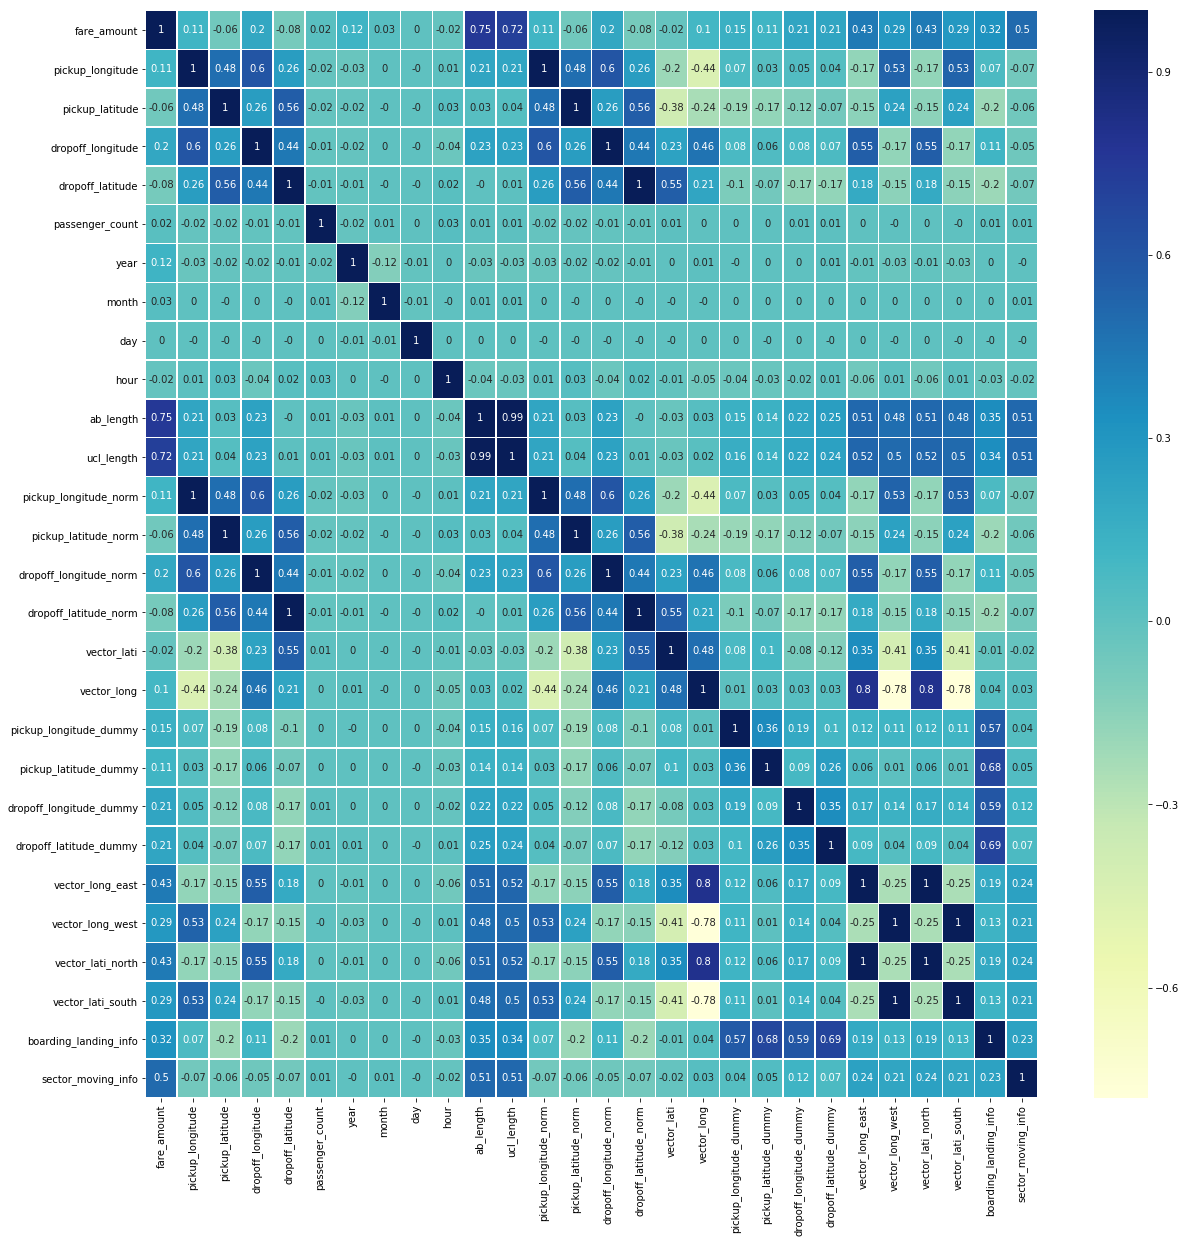

In [16]:
corr_data = data_3.corr().round(2)
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data=corr_data, annot=True, linewidths=.5, ax=ax,cmap="YlGnBu")

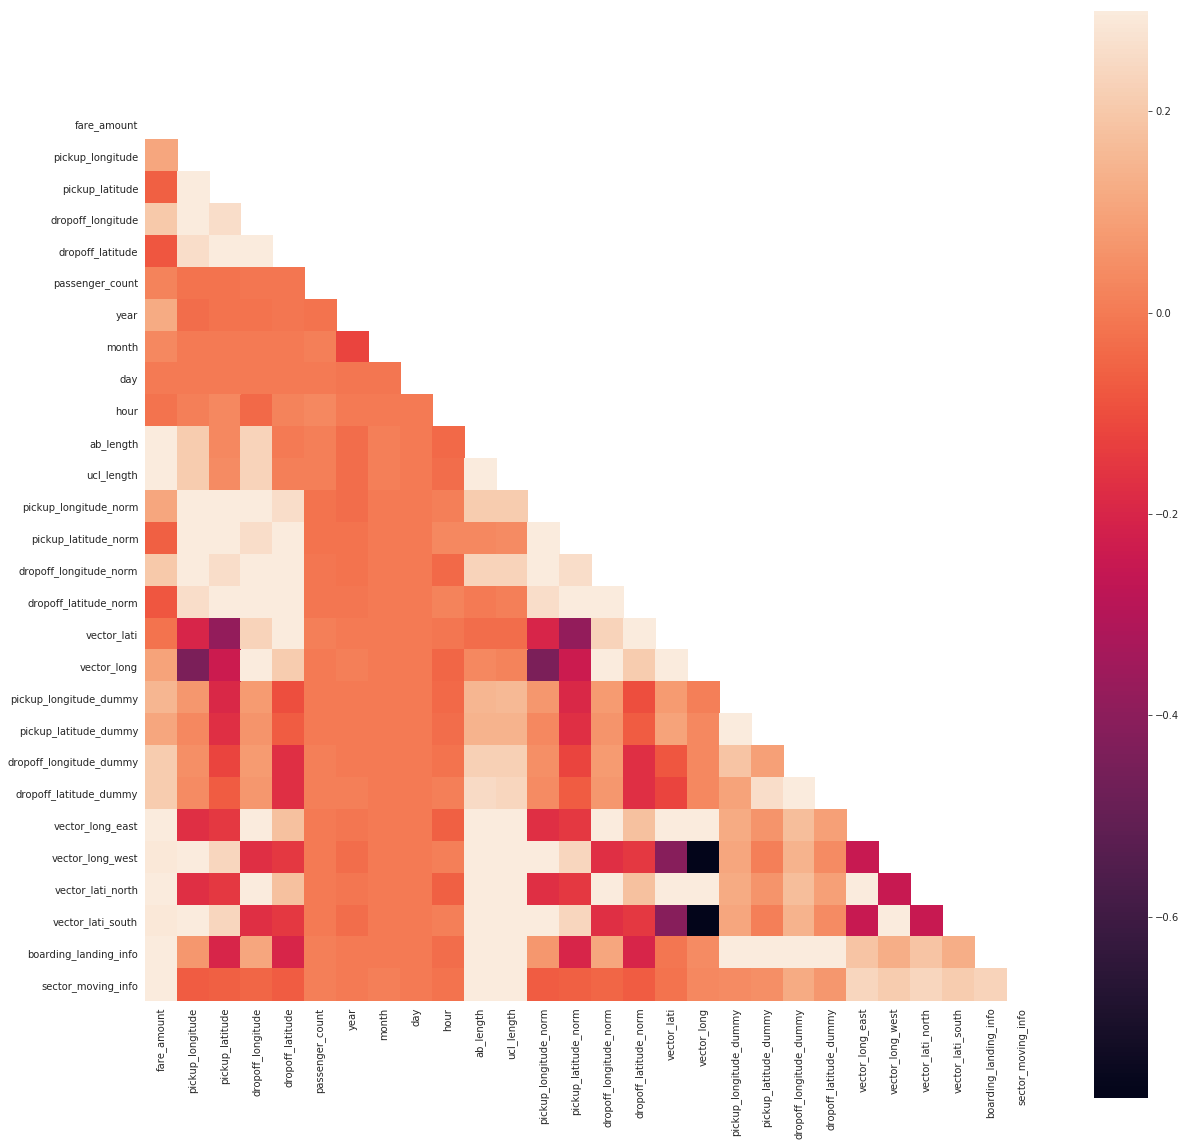

In [17]:
mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(corr_data, mask=mask, vmax=.3, square=True)

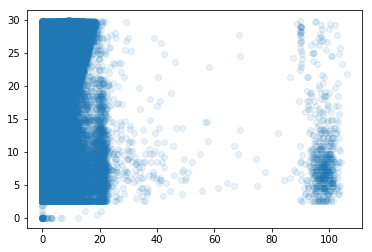

In [31]:
plt.scatter(data_3[data_3.fare_amount>0].ab_length, data_3[data_3.fare_amount>0].fare_amount, alpha=0.1)

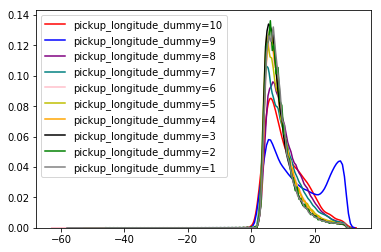

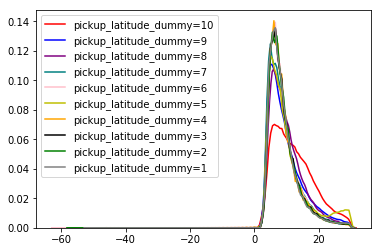

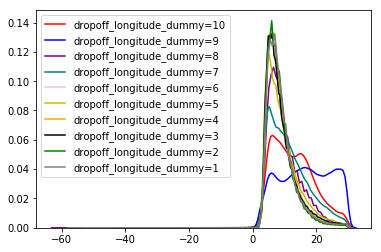

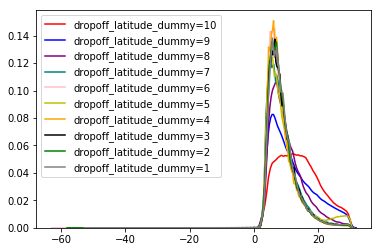

In [19]:
show_kdeplot_of_dummy("pickup_longitude_dummy")
show_kdeplot_of_dummy("pickup_latitude_dummy")
show_kdeplot_of_dummy("dropoff_longitude_dummy")
show_kdeplot_of_dummy("dropoff_latitude_dummy")

### 시간 정보 조회

In [26]:
data_new = data_3[data_3.fare_amount>0]
data_new["ab_length_div_fee"]=data_new["ab_length"] / (data_new["fare_amount"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
data_new[["hour","ab_length_div_fee"]].groupby("hour").mean()

,ab_length_div_fee
hour,
0,0.300073
1,0.316553
2,0.313338
3,0.313059
4,0.321273
5,0.320010
6,0.310687
7,0.286478
8,0.256344


새벽 시간과 낮 시간의 거리당 요금의 가격이 다름을 확인

In [28]:
data_new[["day","ab_length_div_fee"]].groupby("day").mean()

,ab_length_div_fee
day,
1,0.272720
2,0.271853
3,0.280287
4,0.274492
5,0.269732
6,0.269553
7,0.269557
8,0.270025
9,0.270379


날짜 별로는 요금의 차이가 거의 없음을 확인

In [29]:
data_new[["year","ab_length_div_fee"]].groupby("year").mean()

,ab_length_div_fee
year,
2009,0.292093
2010,0.302683
2011,0.285389
2012,0.274141
2013,0.243605
2014,0.238457
2015,0.243082


연도 별로 요금의 차이가 있음을 확인

In [30]:
data_new[["month","ab_length_div_fee"]].groupby("month").mean()

,ab_length_div_fee
month,
1,0.270335
2,0.275470
3,0.269459
4,0.272268
5,0.269826
6,0.270838
7,0.278257
8,0.281617
9,0.278541


월별로 요금의 차이가 있음을 확인

어느정도의 계절성이 있음을 확인

### 시간 정보 수정 및 승하차 위치 더미 변수화, Label 스케일 조정

In [32]:
data_5 = data_3[data_3.fare_amount>-1]
data_5["fare_amount_scaled"]=np.log1p(data_5.fare_amount)
print( "1 is done")

pickup_longitude_dummy = pd.get_dummies(data_5.pickup_longitude_dummy, prefix="pickup_longitude")
pickup_latitude_dummy = pd.get_dummies(data_5.pickup_latitude_dummy, prefix="pickup_latitude")
dropoff_longitude_dummy = pd.get_dummies(data_5.dropoff_longitude_dummy, prefix="dropoff_longitude")
dropoff_latitude_dummy = pd.get_dummies(data_5.dropoff_latitude_dummy, prefix="dropoff_latitude")
data_5= pd.concat([data_5, pickup_longitude_dummy,pickup_latitude_dummy,dropoff_longitude_dummy,dropoff_latitude_dummy],\
                       axis=1)
print( "2 is done")


data_5["night"]=data_5.apply(input_night, axis=1)
print( "3 is done")
year_dummy = pd.get_dummies(data_5.year, prefix="year")
data_5 = pd.concat([data_5, year_dummy], axis=1)
print( "4 is done")
month_dummy = pd.get_dummies(data_5.month, prefix="month")
data_5 = pd.concat([data_5, month_dummy], axis=1)
print( "5 is done")


data_5.drop(columns=["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude",
                     "passenger_count","year","day","month","hour",
                     "pickup_latitude_dummy","pickup_longitude_dummy",
                     "dropoff_latitude_dummy","dropoff_longitude_dummy",
                     "pickup_latitude_norm","pickup_longitude_norm",
                     "dropoff_latitude_norm","dropoff_longitude_norm",
                     "vector_lati","vector_long"], inplace=True)

# Saving Data For backup
print(data_5.shape)
data_5.to_csv("./Data/temp_9.csv", index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1 is done
2 is done
3 is done
4 is done
5 is done
(4200468, 70)


In [3]:
# Load Backup data
fin_train = pd.read_csv("./Data/temp_9.csv")
print(fin_train.shape)
print(fin_train.columns)
fin_train.head()

(4200468, 70)
Index(['fare_amount', 'ab_length', 'ucl_length', 'vector_long_east',
       'vector_long_west', 'vector_lati_north', 'vector_lati_south',
       'boarding_landing_info', 'sector_moving_info', 'fare_amount_scaled',
       'pickup_longitude_1', 'pickup_longitude_2', 'pickup_longitude_3',
       'pickup_longitude_4', 'pickup_longitude_5', 'pickup_longitude_6',
       'pickup_longitude_7', 'pickup_longitude_8', 'pickup_longitude_9',
       'pickup_longitude_10', 'pickup_latitude_1', 'pickup_latitude_2',
       'pickup_latitude_3', 'pickup_latitude_4', 'pickup_latitude_5',
       'pickup_latitude_6', 'pickup_latitude_7', 'pickup_latitude_8',
       'pickup_latitude_9', 'pickup_latitude_10', 'dropoff_longitude_1',
       'dropoff_longitude_2', 'dropoff_longitude_3', 'dropoff_longitude_4',
       'dropoff_longitude_5', 'dropoff_longitude_6', 'dropoff_longitude_7',
       'dropoff_longitude_8', 'dropoff_longitude_9', 'dropoff_longitude_10',
       'dropoff_latitude_1', 'dropoff_l

,fare_amount,ab_length,ucl_length,vector_long_east,vector_long_west,vector_lati_north,vector_lati_south,boarding_landing_info,sector_moving_info,fare_amount_scaled,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,4.5,1.030765,1.232938,0.002701,0.000000,0.002701,0.000000,18.055470,2.000000,1.704748,...,0,0,0,1,0,0,0,0,0,0
1,16.9,8.450145,10.961661,0.036780,0.000000,0.036780,0.000000,14.730920,6.708204,2.884801,...,0,0,0,0,0,0,0,0,0,0
2,5.7,1.389527,1.906911,0.000000,0.008504,0.000000,0.008504,5.744563,2.236068,1.902108,...,0,0,0,0,0,1,0,0,0,0
3,7.7,2.799274,3.148063,0.000000,0.004437,0.000000,0.004437,8.306624,5.000000,2.163323,...,0,1,0,0,0,0,0,0,0,0
4,5.3,1.999160,2.715183,0.011440,0.000000,0.011440,0.000000,10.392305,2.828427,1.840550,...,1,0,0,0,0,0,0,0,0,0


# 4. Modeling

In [4]:
# Split x & y
x = fin_train.drop(columns=["fare_amount","fare_amount_scaled"])
y = fin_train.fare_amount
y_scaled = fin_train.fare_amount_scaled

# Regularize 
x_reg = (x-x.min(axis=0))/(x.max(axis=0)-x.min(axis=0))

# Split train & test
x_train, x_test, y_train, y_test = train_test_split(x_reg, y_scaled, test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3360374, 68)
(840094, 68)
(3360374,)
(840094,)


In [5]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2'},
    #'num_leaves': 200,
    'learning_rate': 0.04,
    
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree':0.8,
    'reg_aplha': 0.001,
    'reg_lambda': 0.001,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 15,
    'random_state':0,    
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                early_stopping_rounds=100)

Starting training...
[1]	valid_0's l2: 0.181664
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.171419
[3]	valid_0's l2: 0.161961
[4]	valid_0's l2: 0.15325
[5]	valid_0's l2: 0.145253
[6]	valid_0's l2: 0.137828
[7]	valid_0's l2: 0.130938
[8]	valid_0's l2: 0.124781
[9]	valid_0's l2: 0.118881
[10]	valid_0's l2: 0.114493
[11]	valid_0's l2: 0.109396
[12]	valid_0's l2: 0.104664
[13]	valid_0's l2: 0.100284
[14]	valid_0's l2: 0.0963936
[15]	valid_0's l2: 0.0926306
[16]	valid_0's l2: 0.0891769
[17]	valid_0's l2: 0.08611
[18]	valid_0's l2: 0.0832507
[19]	valid_0's l2: 0.0804989
[20]	valid_0's l2: 0.077962
[21]	valid_0's l2: 0.0756136
[22]	valid_0's l2: 0.0734408
[23]	valid_0's l2: 0.07152
[24]	valid_0's l2: 0.0696526
[25]	valid_0's l2: 0.0679216
[26]	valid_0's l2: 0.0663266
[27]	valid_0's l2: 0.0648432
[28]	valid_0's l2: 0.0634714
[29]	valid_0's l2: 0.0621938
[30]	valid_0's l2: 0.0609939
[31]	valid_0's l2: 0.0599218
[32]	valid_0's l2: 0.0589387
[33]	valid_0's l2

In [6]:
print('Starting predicting...')
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
print('The mse of prediction is:', mean_squared_error(y_test, y_pred))


print("In trainning set")
train_pred = gbm.predict(x_train, num_iteration=gbm.best_iteration)
print('The mse of prediction is:', mean_squared_error(y_train, train_pred))

Starting predicting...
The mse of prediction is: 0.035101319515668514
In trainning set
The mse of prediction is: 0.03330099806977768


In [7]:
y_pred_trans = np.exp(y_pred)-1
y_test_trans = np.exp(y_test)-1

print('The mse of prediction is:', mean_squared_error(y_test_trans, y_pred_trans))

The mse of prediction is: 4.538192922264376


# 5. Result

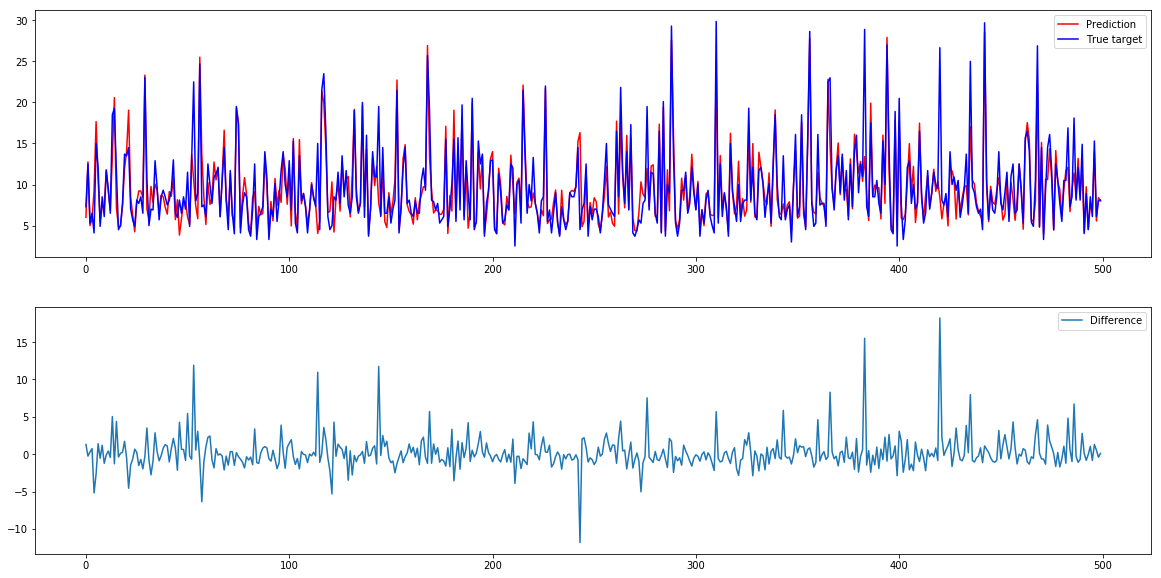

In [8]:
fig = plt.figure(figsize=(20,10))
diff = y_test_trans - y_pred_trans
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(range(500),np.array(y_pred_trans[:500]), color="r", label="Prediction")
ax1.plot(range(500),np.array(y_test_trans[:500]), color="b", label="True target")
ax1.legend()
ax2.plot(range(500),np.array(diff[:500]), label="Difference")
ax2.legend()
plt.show()

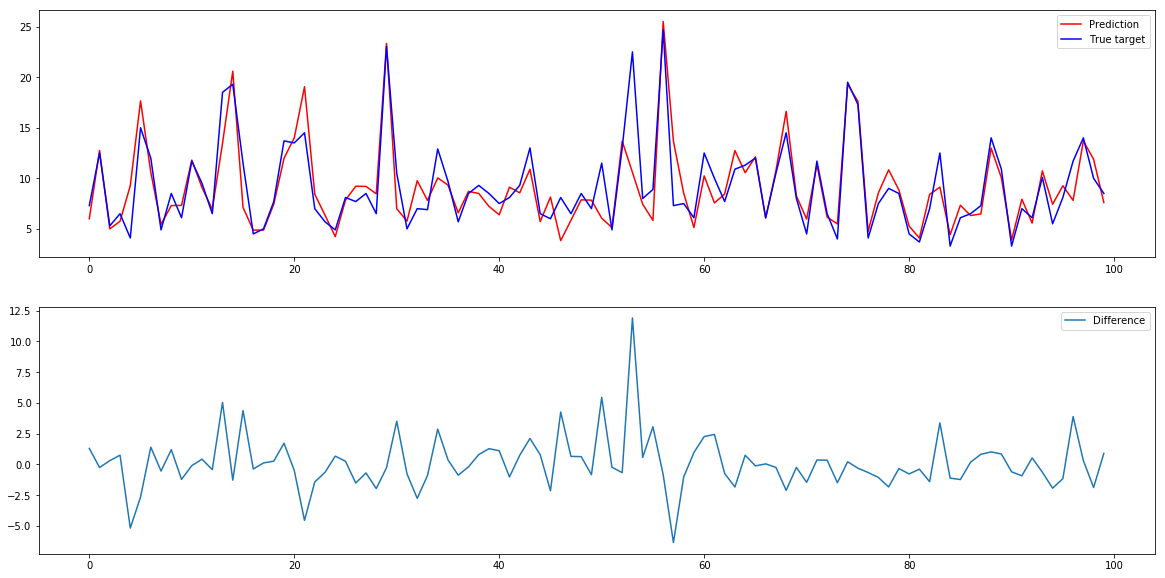

In [9]:
fig = plt.figure(figsize=(20,10))
diff = y_test_trans - y_pred_trans
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(range(100),np.array(y_pred_trans[:100]), color="r", label="Prediction")
ax1.plot(range(100),np.array(y_test_trans[:100]), color="b", label="True target")
ax1.legend()
ax2.plot(range(100),np.array(diff[:100]), label="Difference")
ax2.legend()
plt.show()